In [1]:
import torch
import random
import numpy as np
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
#!pip install deeplake

In [4]:
#!pip install pyjwt

In [5]:
import deeplake

Скачал через deeplake<br>
https://datasets.activeloop.ai/docs/ml/datasets/fer2013-dataset/

In [6]:
FER2013_train = deeplake.load('hub://activeloop/fer2013-train')
FER2013_test = deeplake.load('hub://activeloop/fer2013-public-test')

|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-train



-

hub://activeloop/fer2013-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/fer2013-public-test



-

hub://activeloop/fer2013-public-test loaded successfully.



In [7]:
#FER2013_train нет атрибута train_data, потому что диплэйк использует какой-то другой подход для доступа к данным
#Не понял что диплейк делает с индексацией, и почему всё ломается, поэтому просто преобразовал к numpy
X_train = torch.tensor(FER2013_train.images.numpy())
y_train = torch.tensor(FER2013_train.labels.numpy())

X_test = torch.tensor(FER2013_test.images.numpy())
y_test = torch.tensor(FER2013_test.labels.numpy())

Преобразовал числовые в категориальные данные

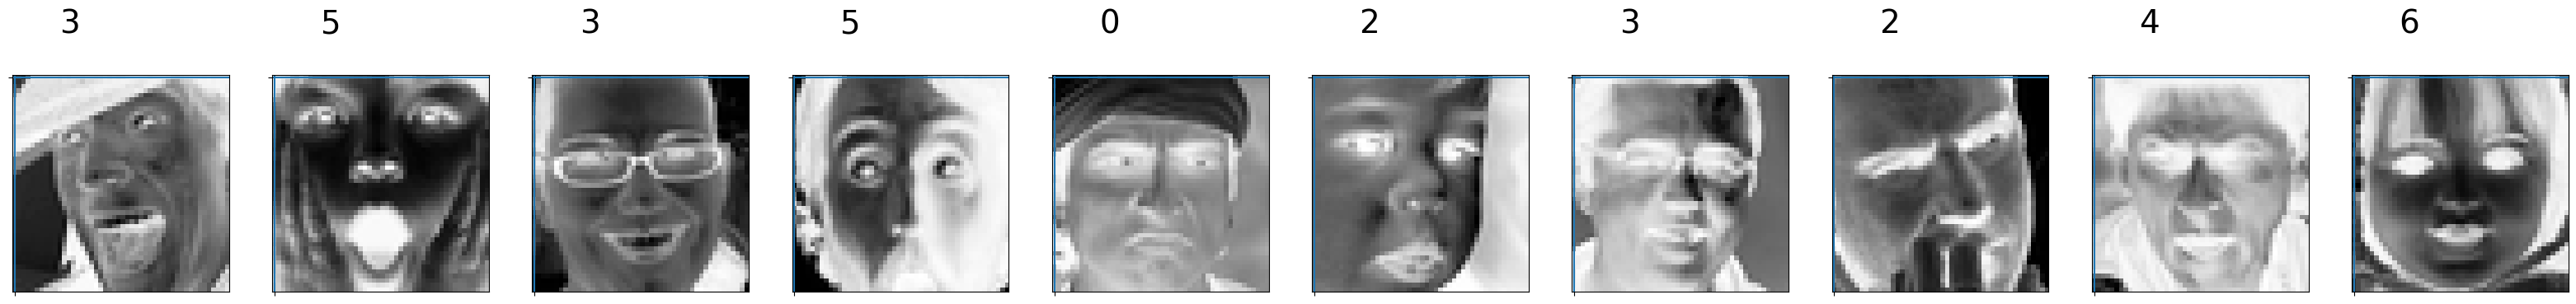

In [8]:
# посмотрим, что пришло
import matplotlib.pyplot as plt

count = 0
sample_size = 10  # сколько картинок будем смотреть
plt.figure(figsize=(40, 20))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i].item(), fontsize=28)
    plt.imshow(X_train[i].reshape(48, 48), cmap=plt.cm.Greys)
plt.show()

In [9]:
len(y_train), len(y_test)

(28709, 3589)

image:
tensor([[ 30,  24,  21,  ...,  37,  44,  37],
        [ 31,  22,  21,  ...,  37,  35,  41],
        [ 27,  22,  19,  ...,  33,  34,  40],
        ...,
        [ 29,  29,  26,  ..., 118, 132, 148],
        [ 30,  30,  27,  ..., 154, 159, 166],
        [ 32,  29,  28,  ..., 172, 173, 173]], dtype=torch.uint8)


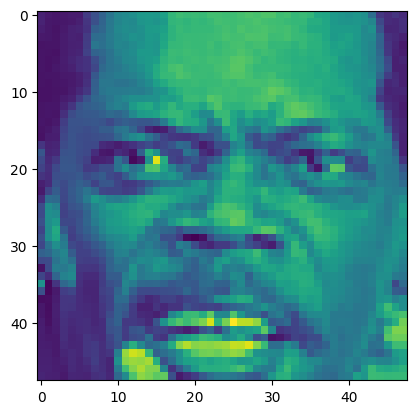

tensor([0], dtype=torch.uint32)


In [10]:
# нарисуем, c чем мы имеем дело
import matplotlib.pyplot as plt

im_number = 10

# вот как хранятся изображения в компьютере
print(f"image:\n{X_train[im_number, :, :]}")

# а так их видим мы
plt.imshow(X_train[im_number, :, :])

plt.show()
print(y_train[im_number])

In [11]:
# посмотртим тип "картинок"
type(X_train[10, :, :])

torch.Tensor

In [12]:
X_train.shape

torch.Size([28709, 48, 48])

In [13]:
# unsqueeze - Возвращает новый тензор с увеличенной на 1 размерностью, которая вставляется в указанную позицию.
# было torch.Size([28709, 48, 48])  ---- станет torch.Size([28709, 1, 48, 48])
# и все значения - во float

X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [14]:
X_train.shape

torch.Size([28709, 1, 48, 48])

In [15]:
X_test.shape

torch.Size([3589, 1, 48, 48])

In [16]:
# Определяем класс, которые и будет представлять нашу нейронку
# какие слои - см описание вначале блокнота

class LeNet5(torch.nn.Module):
    # конструктор. Определям вообще какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU() #с релу быстрее обучается, и точность с гиперьболическим тангенсом не прывашала 0,45
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(1600, 120)
        self.act3  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(84, 7)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [17]:
# определяем, где будет обучаться наша СNN
# если есть граф процессор от Nvidia, то на нем. Если нет, то на cpu

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = "cpu"

# отправляем туда нашу нейронку
lenet5 = lenet5.to(device)

In [18]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [19]:
# будем оптимизировать по 100 параметров одним комплектом (бачем)
batch_size = 100

# чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []

train_loss_history = []

# не забываем отправить все выборки на устройство, на котором обучаем
X_test = X_test.to(device)
y_test = y_test.to(device)

# Преобразование в 1д тензер
y_train = y_train.view(-1).long()
y_test = y_test.view(-1).long()

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # делаем предсказание
        preds = lenet5.forward(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.4048481583595276 
epoch1 - accuracy test 0.43772637844085693 
epoch2 - accuracy test 0.44692113995552063 
epoch3 - accuracy test 0.47924211621284485 
epoch4 - accuracy test 0.48063528537750244 
epoch5 - accuracy test 0.48983004689216614 
epoch6 - accuracy test 0.4731122851371765 
epoch7 - accuracy test 0.4597380757331848 
epoch8 - accuracy test 0.4825856685638428 
epoch9 - accuracy test 0.4993034303188324 
epoch10 - accuracy test 0.47979938983917236 
epoch11 - accuracy test 0.4845360815525055 
epoch12 - accuracy test 0.476734459400177 
epoch13 - accuracy test 0.47004735469818115 
epoch14 - accuracy test 0.47979938983917236 
epoch15 - accuracy test 0.4647534191608429 
epoch16 - accuracy test 0.4661465585231781 
epoch17 - accuracy test 0.4795207679271698 
epoch18 - accuracy test 0.47506269812583923 
epoch19 - accuracy test 0.4611312448978424 
epoch20 - accuracy test 0.47283366322517395 
epoch21 - accuracy test 0.45750904083251953 
epoch22 - accuracy test 0.461131

C:\Users\Серега\AppData\Local\Temp\ipykernel_15668\422858666.py:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


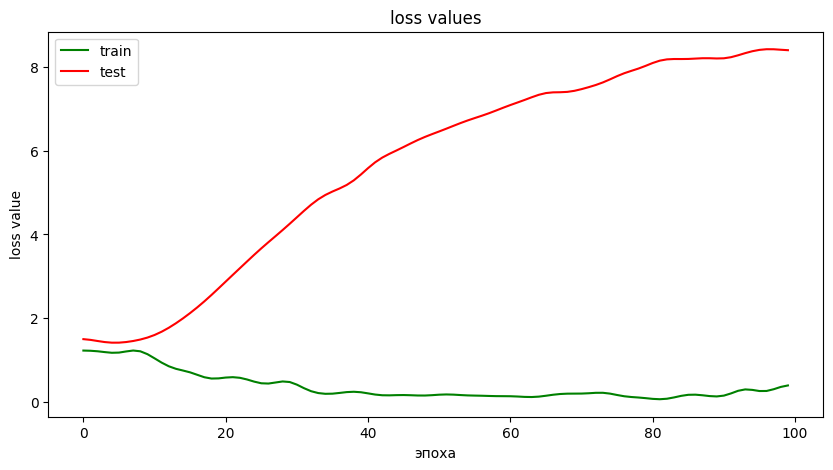

In [37]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



C:\Users\Серега\AppData\Local\Temp\ipykernel_15668\2679742005.py:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


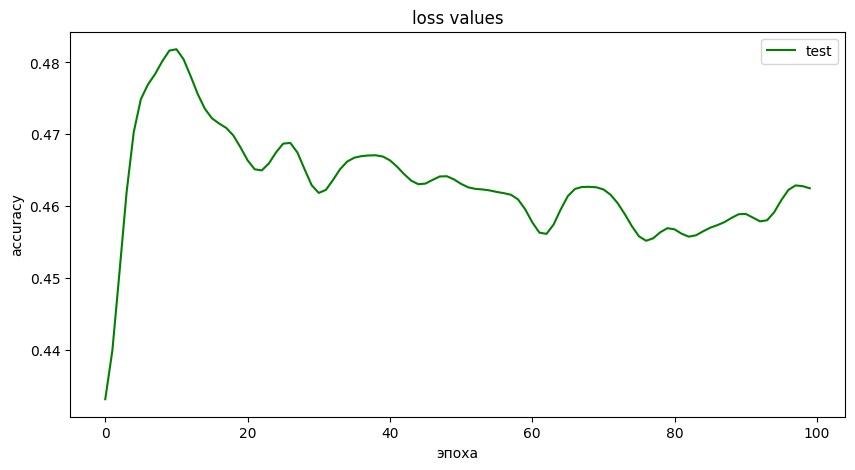

In [42]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [39]:
timg = X_train[264]

torch.save(timg,'tensor.pt')

In [40]:
y_train[264]

tensor(2)

In [41]:
# смотрим размер тензора - изображения
timg.size()

torch.Size([1, 48, 48])

In [25]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

X_test.size()


torch.Size([3589, 1, 48, 48])

In [43]:
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)


In [44]:
# считываем модель, сохраненную в dill
import torch
import torch.nn as nn
#from LeNET_5 import LeNet
import pandas as pd
import numpy as np



ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)


C:\Users\Серега\AppData\Local\Temp\ipykernel_15668\205738607.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


In [45]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

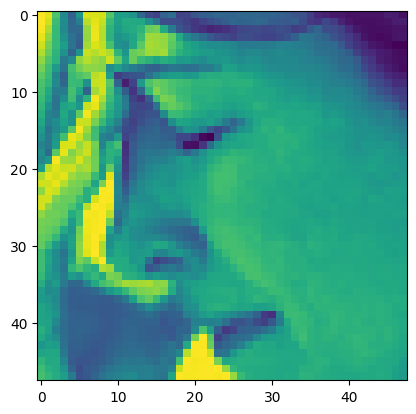

In [46]:
plt.imshow(test_data[0, :, :])
plt.show()

In [47]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

In [48]:
# проверяем
t_data.shape

torch.Size([1, 1, 48, 48])

In [49]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [50]:
# делаем предсказание
preds = modelp.forward(t_data)

In [51]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[  0.2059, -29.7175,  13.3667, -24.5758,   1.1979,   4.3384, -33.4244]],
       grad_fn=<AddmmBackward0>)


In [52]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [53]:
# смотрим, что предсказалось
print(prediction)

[2]


 0 = Гнев, 1 = Отвращение, 2 = Страх, 3 = Счастье, 4 = Грусть, 5 = Удивление, 6 = Нейтральность <br>
Это страх